In [83]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import nltk
import tensorflow as tf
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline,
    BertTokenizer,
    BertForSequenceClassification,
    BertModel,
    Trainer,
    TrainingArguments,
    TrainerCallback,
    EarlyStoppingCallback,
)
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_absolute_error,
    accuracy_score,
    mean_squared_error,
    r2_score,
    f1_score,
)

import seaborn as sns
from scipy import stats

from datasets import Dataset
from collections import defaultdict

In [37]:
news_df = pd.read_csv('data/news.csv')
stock_df = pd.read_csv('data/price.csv')


In [ ]:
stock_df.head()

## Pretrained FinBERT and VADER Sentiment Scoring 

In [ ]:
def FinBERT_sentiment_score(heading, max_length=512):
    """
    compute sentiment score using pretrained FinBERT on -1 to 1 scale. -1 being negative and 1 being positive
    """
    try:
        tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-tone')
        finbert = AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')
        
        # If heading is a list, join it into a single string
        if isinstance(heading, list):
            heading = ' '.join(heading)
            
        # Truncate text if it's too long
        tokens = tokenizer(heading, truncation=True, max_length=max_length, return_tensors="pt")
        
        # Get prediction
        with torch.no_grad():
            outputs = finbert(**tokens)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
            
        # Get the highest probability class
        predicted_class = torch.argmax(predictions).item()
        score = predictions[0][predicted_class].item()
        
        # Map the prediction to -1 to 1 scale
        if predicted_class == 0:  # negative
            return -score
        elif predicted_class == 1:  # neutral
            return 0
        else:  # positive
            return score
            
    except Exception as e:
        print(f"Error processing text: {str(e)}")
        return 0  # Return neutral sentiment in case of error

def VADER_sentiment_score(heading):
    """
    compute sentiment score using pretrained VADER on -1 to 1 scale. -1 being negative and 1 being positive
    """
    try:
        nltk.download('vader_lexicon', quiet=True)
        analyzer = SentimentIntensityAnalyzer()
        
        # If heading is a list, join it into a single string
        if isinstance(heading, list):
            heading = ' '.join(heading)
            
        result = analyzer.polarity_scores(heading)
        if result['pos'] == max(result['neg'], result['neu'], result['pos']):
            return result['pos']
        if result['neg'] == max(result['neg'], result['neu'], result['pos']):
            return (0 - result['neg'])
        else:
            return result['neu']
    except Exception as e:
        print(f"Error processing text with VADER: {str(e)}")
        return 0

# Process news data in batches
def process_news_batch(news_df, batch_size=100):
    BERT_sentiment = []
    VADER_sentiment = []
    
    for i in range(0, len(news_df), batch_size):
        batch = news_df.iloc[i:i+batch_size]
        print(f"Processing batch {i//batch_size + 1}/{(len(news_df)-1)//batch_size + 1}")
        
        for idx in range(len(batch)):
            news_list = batch.iloc[idx]['title']
            news_body = batch.iloc[idx]['body']
            
            # Get sentiment scores
            score_BERT = FinBERT_sentiment_score(news_body)
            score_VADER = VADER_sentiment_score(news_list)
            
            BERT_sentiment.append(score_BERT)
            VADER_sentiment.append(score_VADER)
            
            # Clear GPU memory if using CUDA
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    return BERT_sentiment, VADER_sentiment

# Load and process data
news_df = pd.read_csv("data/news.csv")
BERT_sentiment, VADER_sentiment = process_news_batch(news_df)

# Add sentiment scores to dataframe
news_df['FinBERT score'] = BERT_sentiment
news_df['VADER score'] = VADER_sentiment
news_df['combined_sentiment'] = (news_df['FinBERT score'] + news_df['VADER score']) / 2

# Save results

In [8]:
# news_df.to_csv('data/news_w_sentiment.csv', index=False)

news_df.to_csv("data/news_w_sentiment2.csv", index=False)

In [28]:
df = pd.read_csv("data/news_w_sentiment2.csv")
df.head()


,publication_datetime,title,body,tickers,FinBERT score,VADER score,combined_sentiment
0,2017-01-03,World News: Police Question Netanyahu Over Gifts,"""We pay attention to publications in the media...",EL,-0.999937,1.000,0.000031
1,2017-01-03,Business News: Nestle Turns to New CEO for Hea...,"Nestle, the world's largest packaged-food comp...",GIS,0.000000,1.000,0.500000
2,2017-01-03,Business News: Vermont Drug Law Faces Limits -...,"The Vermont law, enacted in June, instructed s...",ABBV,-0.999891,1.000,0.000054
3,2017-01-03,Life & Arts -- Travel: How Hotel Companies Lau...,Travelers are about to see a flurry of new hot...,HLT,-0.999991,1.000,0.000005
4,2017-01-03,Businesses Ready to Ramp Up Investment --- Aft...,The Federal Reserve last month signaled intere...,HD,-0.984549,0.894,-0.045275


In [71]:
def calculate_r2(y_true, y_pred, in_sample=True, benchmark=None):
    if in_sample:
        return 1 - (
            np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)
        )
    else:
        if benchmark is None:
            raise ValueError(
                "Benchmark must be provided for out-of-sample R-squared calculation."
            )
        return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - benchmark) ** 2))


Epoch 1/15

27/27 [==============================] - 4s 42ms/step - loss: 0.0292 - val_loss: 0.0535
Epoch 2/15
27/27 [==============================] - 0s 8ms/step - loss: 0.0034 - val_loss: 0.0224
Epoch 3/15
27/27 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 0.0128
Epoch 4/15
27/27 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 0.0107
Epoch 5/15
27/27 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0128
Epoch 6/15
27/27 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0191
Epoch 7/15
27/27 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0049
Epoch 8/15
27/27 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 9/15
27/27 [==============================] - 0s 9ms/step - loss: 0.0017 - val_loss: 0.0053
Epoch 10/15
27/27 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 11/15
27/2

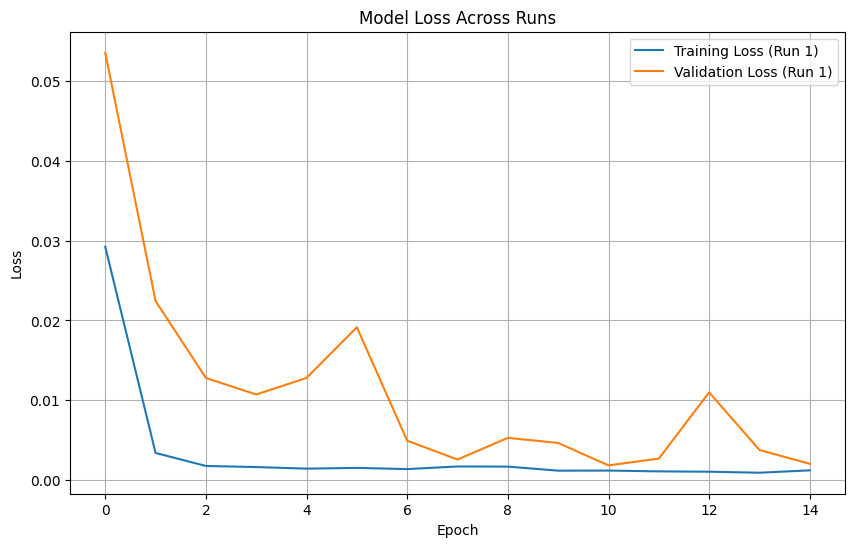

In [74]:

# hyperparameters
split = (0.85);
sequence_length = 10;
epochs = 15
learning_rate = 0.01


# loading stock price and news data
stock_data = pd.read_csv("data/price.csv")
news_data = pd.read_csv("data/news_w_sentiment2.csv")

# news_data['FinBERT score'] = news_data['positive'] - news_data['negative']


sp = stock_data[stock_data['ticker'] == 'SPX']
stock_column = ['close']
news_column = ['combined_sentiment']

len_stock_data = sp.shape[0]

# splitting data to train and test
train_examples = int(len_stock_data * split)
train = sp.get(stock_column).values[:train_examples]
train_sentiment = news_data.get(news_column).values[:train_examples]
test = sp.get(stock_column).values[train_examples:]
test_sentiment = news_data.get(news_column).values[train_examples:]
len_train = train.shape[0]
len_test = test.shape[0]
len_train_sentiment = train_sentiment.shape[0]
len_test_sentiment = test_sentiment.shape[0]


# normalizing data
scaler = MinMaxScaler()
train, test = scaler.fit_transform(train), scaler.fit_transform(test)


# splitting training data to x and y
X_train = []
for i in range(len_train - sequence_length):
    X_train.append(train[i : i + sequence_length])
len_X_train = len(X_train)
y_train = np.array(train[sequence_length:]).astype(float)


# splitting testing data to x and y
X_test = []
for i in range(len_test - sequence_length):
    X_test.append(test[i : i + sequence_length])
len_X_test = len(X_test)
y_test = np.array(test[sequence_length:]).astype(float)


# adding news sentiment to train and test
for i in range(len_X_train):
    X_train[i] = X_train[i].tolist()
    # Check if we have sentiment data
    if len_train_sentiment > 0:
        if i + sequence_length < len_train_sentiment:
            X_train[i].append(train_sentiment[i + sequence_length].tolist())
        else:
            # If we're at the end, use the last available sentiment
            X_train[i].append(train_sentiment[-1].tolist())
    else:
        # If no sentiment data, append 0
        X_train[i].append([0.0])
X_train = np.array(X_train).astype(float)

for i in range(len_X_test):
    X_test[i] = X_test[i].tolist()
    # Check if we have sentiment data
    if len_test_sentiment > 0:
        if i + sequence_length < len_test_sentiment:
            X_test[i].append(test_sentiment[i + sequence_length].tolist())
        else:
            # If we're at the end, use the last available sentiment
            X_test[i].append(test_sentiment[-1].tolist())
    else:
        # If no sentiment data, append 0
        X_test[i].append([0.0])
X_test = np.array(X_test).astype(float)

def calculate_r2(y_true, y_pred, in_sample=True, benchmark=None):
    if in_sample:
        return 1 - (np.sum((y_true - y_pred) ** 2) / 
                    np.sum((y_true - np.mean(y_true)) ** 2))
    else:
        if benchmark is None:
            raise ValueError("Benchmark must be provided for out-of-sample R-squared calculation.")
        return 1 - (np.sum((y_true - y_pred) ** 2) / 
                    np.sum((y_true - benchmark) ** 2))

#%%
#creating LSTM model
def model_create():
    tf.random.set_seed(1234)
    model = tf.keras.models.Sequential(
        [
            tf.keras.Input(shape = (X_train.shape[1], 1)),
            tf.keras.layers.LSTM(units = 50, activation = "tanh", return_sequences = True),
            tf.keras.layers.LSTM(units = 30, activation = "tanh", return_sequences = True),
            tf.keras.layers.LSTM(units = 20, activation = "tanh", return_sequences = False),
            tf.keras.layers.Dense(units = 1, activation = "linear")
        ]
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    )

    # Split training data into training and validation sets (80-20 split)
    val_split = 0.2
    val_size = int(len(X_train) * val_split)
    
    X_val = X_train[-val_size:]
    y_val = y_train[-val_size:]
    X_train_new = X_train[:-val_size]
    y_train_new = y_train[:-val_size]

    # Train the model with validation data
    history = model.fit(
        X_train_new, y_train_new,
        validation_data=(X_val, y_val),
        epochs = epochs,
        verbose=1
    )
    
    return model, history

#%%

# inverting normaliztion
y_test = scaler.inverse_transform(y_test)



# prediction on test set
def predict(model):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1,1)).reshape(-1,1)
    return predictions



# evaluation
def evaluate(predictions):
    # Existing metrics
    mae = mean_absolute_error(predictions, y_test)
    mape = mean_absolute_percentage_error(predictions, y_test)
    r2 = calculate_r2(y_test, predictions, in_sample=False, benchmark=0)
    
    # Convert predictions and actual values to binary classes (1 for increase, 0 for decrease)
    y_pred_binary = np.where(np.diff(predictions.flatten()) > 0, 1, 0)
    y_true_binary = np.where(np.diff(y_test.flatten()) > 0, 1, 0)
    
    # Calculate F1 score
    f1 = f1_score(y_true_binary, y_pred_binary)
    
    return mae, mape, (1 - mape), r2, f1

# trial runs
def run_model(n):
    total_mae = total_mape = total_acc = total_r2 = total_f1 = 0
    histories = []
    global predictions
    for i in range(n):
        model, history = model_create()
        predictions = predict(model)
        mae, mape, acc, r2, f1 = evaluate(predictions)
        total_mae += mae
        total_mape += mape 
        total_acc += acc
        total_r2 += r2
        total_f1 += f1
        histories.append(history)
    return (total_mae / n), (total_mape / n), (total_acc / n), (total_r2 / n), (total_f1 / n), histories

# Run the model and get the histories
mae, mape, acc, r2, f1, histories = run_model(1)

print(f"Mean Absolute Error = {mae}")
print(f"Mean Absolute Percentage Error = {mape}%")
print(f"Accuracy = {acc}")
print(f"R-squared = {r2}")
print(f"F1 Score = {f1}")
# Plot the final training and validation loss
plt.figure(figsize=(10, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Training Loss (Run {i+1})')
    plt.plot(history.history['val_loss'], label=f'Validation Loss (Run {i+1})')
plt.title('Model Loss Across Runs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
# %%


## Fine-Tuned FinBERT

In [53]:

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-merged dataset of news and price data
price_df = pd.read_csv('data/price.csv')
news_df = pd.read_csv('data/news.csv')

price_df['daily_return'] = price_df.groupby('ticker')['close'].transform(lambda x: x.pct_change())
price_df = price_df.dropna()

# Convert dates to datetime
news_df['publication_datetime'] = pd.to_datetime(news_df['publication_datetime'])
price_df['Date'] = pd.to_datetime(price_df['Date'])

price_df = price_df.sort_values(['ticker', "Date"])
price_df['daily_return'] = price_df.groupby('ticker')['close'].pct_change()

news_df = news_df.rename(columns={'tickers': 'ticker'})

merged_df = pd.merge_asof(
    news_df.sort_values('publication_datetime'),
    price_df.sort_values('Date'),
    by='ticker',
    left_on='publication_datetime',
    right_on='Date',
    direction='backward'
)
merged_df = merged_df.dropna(subset=['daily_return'])

# Keep the date column for splitting
merged_df = merged_df[["title", "body", "daily_return", "Date"]].dropna()
merged_df["text"] = merged_df["title"] + " " + merged_df["body"]
merged_df["label"] = (merged_df["daily_return"] > 0).astype(int)
merged_df["label"] = merged_df["label"].astype(float)

# Split data based on dates
train_mask = merged_df['Date'] < '2019-01-01'
val_mask = (merged_df['Date'] >= '2019-01-01') & (merged_df['Date'] < '2020-01-01')
test_mask = merged_df['Date'] >= '2020-01-01'


Using device: cuda


In [54]:

# Create clean dataframes with only the columns we need
train_df = pd.DataFrame({
    'text': merged_df.loc[train_mask, 'text'].values,
    'label': merged_df.loc[train_mask, 'label'].values
})
val_df = pd.DataFrame({
    'text': merged_df.loc[val_mask, 'text'].values,
    'label': merged_df.loc[val_mask, 'label'].values
})
test_df = pd.DataFrame({
    'text': merged_df.loc[test_mask, 'text'].values,
    'label': merged_df.loc[test_mask, 'label'].values
})

# Ensure all values are numeric
train_df['label'] = train_df['label'].astype(float)
val_df['label'] = val_df['label'].astype(float)
test_df['label'] = test_df['label'].astype(float)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Create datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)


Training set size: 10292
Validation set size: 5338
Test set size: 4892


In [55]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map: 100%|██████████| 4892/4892 [00:42<00:00, 115.36 examples/s]


In [ ]:


def compute_metrics(pred):
    # Handle the prediction format correctly
    if isinstance(pred, tuple):
        if len(pred) == 2:
            logits, labels = pred
        else:
            logits = pred[0]
            labels = pred[1]
    else:
        logits = pred.predictions
        labels = pred.label_ids
    
    # Ensure we have the right shape
    if len(logits.shape) > 1:
        logits = logits.squeeze()
    
    if isinstance(logits, torch.Tensor):
        logits = logits.detach().cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()
    
    # Ensure we're working with float arrays
    logits = logits.astype(np.float32)
    labels = labels.astype(np.float32)
    
    probs = 1 / (1 + np.exp(-logits))
    preds = (probs > 0.5).astype(int)
    
    # Calculate additional metrics
    mse = mean_squared_error(labels, probs)
    
    metrics = {
        "accuracy": accuracy_score(labels, preds),
        "mse": mse
    }
    return metrics

# Initialize dictionaries to store metrics
train_metrics = defaultdict(list)
val_metrics = defaultdict(list)

# Enhanced metrics callback
class MetricsCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            # Check for training loss
            if "loss" in logs:
                train_metrics["loss"].append(logs["loss"])
            # Check for eval loss
            if "eval_loss" in logs:
                val_metrics["loss"].append(logs["eval_loss"])
            # Print current metrics
            print(f"Step {state.global_step}: ", end="")
            if "loss" in logs:
                print(f"Training Loss: {logs['loss']:.4f}", end=" ")
            if "eval_loss" in logs:
                print(f"Eval Loss: {logs['eval_loss']:.4f}", end=" ")
            print()

### Experiment A

In [ ]:

class FinBERTWithClassifier(nn.Module):
    def __init__(self):
        super(FinBERTWithClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        
        # Freeze BERT layers initially
        for param in self.bert.parameters():
            param.requires_grad = False
            
        # Enhanced classifier network with batch normalization and more layers
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )
        self.to(device)

    def forward(self, input_ids, attention_mask, labels=None):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        if labels is not None:
            labels = labels.to(device)
            
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        
        # Add residual connection
        logits = self.classifier(pooled_output).squeeze(-1)

        if labels is not None:
            loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(logits, labels.float())
            return {"loss": loss, "logits": logits}
        return {"logits": logits}


### Experiment B

In [5]:
class FinBERTWithClassifier(nn.Module):
    def __init__(self):
        super(FinBERTWithClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("yiyanghkust/finbert-tone")

        
        # Freeze BERT layers initially
        for param in self.bert.parameters():
            param.requires_grad = False
            
        # Enhanced classifier network with batch normalization and more layers
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )
        self.to(device)

    def forward(self, input_ids, attention_mask, labels=None):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        if labels is not None:
            labels = labels.to(device)
            
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        
        # Add residual connection
        logits = self.classifier(pooled_output).squeeze(-1)

        if labels is not None:
            loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(logits, labels.float())
            return {"loss": loss, "logits": logits}
        return {"logits": logits}


### Experiment C

In [12]:

class FinBERTWithClassifier(nn.Module):
    def __init__(self):
        super(FinBERTWithClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("yiyanghkust/finbert-tone")
        
        # Freeze BERT layers initially
        for param in self.bert.parameters():
            param.requires_grad = False
            
        # Modified classifier network with new dimensions and dropout rates
        self.classifier = nn.Sequential(
            nn.Linear(768, 384),
            nn.LayerNorm(384),  # Changed from BatchNorm to LayerNorm
            nn.ReLU(),
            nn.Dropout(0.5),    # Changed dropout rate
            
            nn.Linear(384, 192),
            nn.LayerNorm(192),  # Changed from BatchNorm to LayerNorm
            nn.ReLU(),
            nn.Dropout(0.4),    # Changed dropout rate
            
            nn.Linear(192, 1),
            nn.Dropout(0.3)     # Final dropout rate
        )
        self.to(device)

    def forward(self, input_ids, attention_mask, labels=None):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        if labels is not None:
            labels = labels.to(device)
            
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        
        logits = self.classifier(pooled_output).squeeze(-1)

        if labels is not None:
            loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(logits, labels.float())
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

### Experiment D

In [56]:

class FinBERTWithClassifier(nn.Module):
    def __init__(self):
        super(FinBERTWithClassifier, self).__init__()
        # Change to bert-large-uncased
        self.bert = BertModel.from_pretrained("bert-large-uncased")
        
        # Freeze BERT layers initially
        for param in self.bert.parameters():
            param.requires_grad = False
            
        # BERT-large has 1024 output dimension
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1024),  # Changed from 768 to 1024 to match BERT-large output
            nn.BatchNorm1d(1024),
            nn.GELU(),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.2),
            
            nn.Linear(256, 1)
        )
        self.to(device)

    def forward(self, input_ids, attention_mask, labels=None):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        if labels is not None:
            labels = labels.to(device)
            
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # This will be 1024-dimensional for bert-large
        
        logits = self.classifier(pooled_output).squeeze(-1)

        if labels is not None:
            loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(logits, labels.float())
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

In [57]:

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=15,  # This will run for all 15 epochs
    weight_decay=0.01,
    warmup_ratio=0.1,
    gradient_accumulation_steps=4,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    lr_scheduler_type="cosine",
    logging_strategy="epoch",
    logging_dir="./logs",
    report_to=["tensorboard"]
)

c:\Users\drebi\miniconda3\envs\FinBERT\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [58]:

model = FinBERTWithClassifier()

In [59]:
# Initialize the trainer with callbacks
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[MetricsCallback()]  # Only include the metrics callback
)
trainer.train()

# Plot training and validation loss curves


Epoch,Training Loss,Validation Loss,Accuracy,Mse
1,0.719800,0.689745,0.533158,0.248303
2,0.710600,0.691348,0.530536,0.249100
3,0.708500,0.691330,0.532409,0.249045
4,0.705200,0.691076,0.533346,0.248946
5,0.705600,0.692784,0.515736,0.249800
6,0.702000,0.695557,0.499063,0.251168
7,0.702500,0.694976,0.515362,0.250897
8,0.701800,0.693735,0.509554,0.250276
9,0.702900,0.693156,0.517797,0.249993
10,0.701000,0.695735,0.505245,0.251269


Step 161: Training Loss: 0.7198 
Step 161: Eval Loss: 0.6897 
Step 322: Training Loss: 0.7106 
Step 322: Eval Loss: 0.6913 
Step 483: Training Loss: 0.7085 
Step 483: Eval Loss: 0.6913 
Step 644: Training Loss: 0.7052 
Step 644: Eval Loss: 0.6911 
Step 805: Training Loss: 0.7056 
Step 805: Eval Loss: 0.6928 
Step 966: Training Loss: 0.7020 
Step 966: Eval Loss: 0.6956 
Step 1127: Training Loss: 0.7025 
Step 1127: Eval Loss: 0.6950 
Step 1288: Training Loss: 0.7018 
Step 1288: Eval Loss: 0.6937 
Step 1449: Training Loss: 0.7029 
Step 1449: Eval Loss: 0.6932 
Step 1610: Training Loss: 0.7010 
Step 1610: Eval Loss: 0.6957 
Step 1771: Training Loss: 0.6996 
Step 1771: Eval Loss: 0.6950 
Step 1932: Training Loss: 0.7028 
Step 1932: Eval Loss: 0.6952 
Step 2093: Training Loss: 0.7002 
Step 2093: Eval Loss: 0.6943 
Step 2254: Training Loss: 0.6995 
Step 2254: Eval Loss: 0.6952 
Step 2415: Training Loss: 0.6987 
Step 2415: Eval Loss: 0.6952 
Step 2415: 


TrainOutput(global_step=2415, training_loss=0.7040395669561983, metrics={'train_runtime': 995.125, 'train_samples_per_second': 155.136, 'train_steps_per_second': 2.427, 'total_flos': 0.0, 'train_loss': 0.7040395669561983, 'epoch': 15.0})

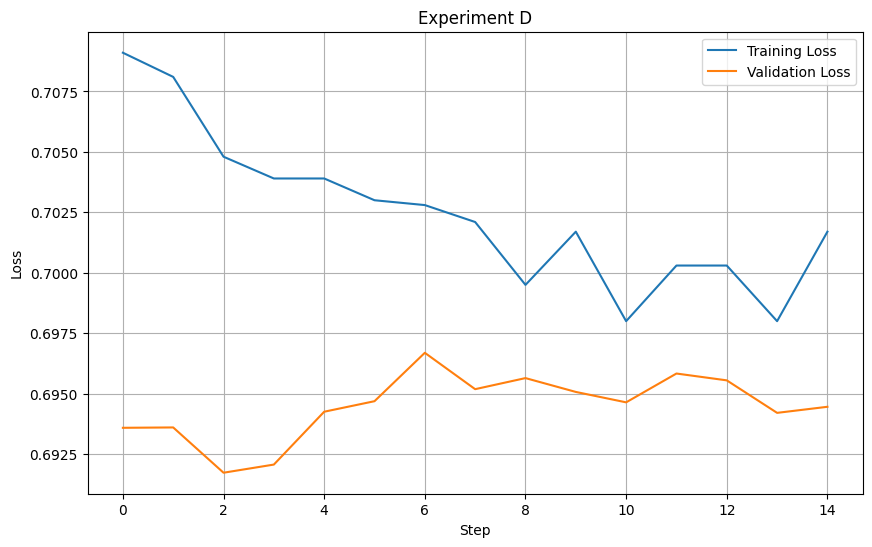

In [31]:
plt.figure(figsize=(10, 6))
if train_metrics["loss"]:  # Check if we have training loss data
    plt.plot(train_metrics["loss"], label="Training Loss")
if val_metrics["loss"]:  # Check if we have validation loss data
    plt.plot(val_metrics["loss"], label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Experiment D")
plt.legend()
plt.grid(True)
plt.savefig("loss_curves.png")
plt.show()


In [61]:
# After training, evaluate on test set
test_results = trainer.evaluate(test_dataset)
print("\nTest Set Results:")
print(test_results)

# Get predictions for the test set
test_preds = trainer.predict(test_dataset)
test_probs = 1 / (1 + np.exp(-test_preds.predictions))
test_labels = test_preds.label_ids

# Create sentiment predictions and scores
test_predictions = np.where(test_probs > 0.5, 'Positive', 'Negative')
sentiment_scores = np.where(test_probs > 0.5, test_probs, 1 - test_probs)

# Create output dataframe
predictions_df = pd.DataFrame({
    'text': test_df['text'].values,
    'true_label': test_labels,
    'true_sentiment': np.where(test_labels > 0.5, 'Positive', 'Negative'),
    'predicted_sentiment': test_predictions,
    'sentiment_score': sentiment_scores
})

# Save predictions to CSV
predictions_df.to_csv('test_predictions.csv', index=False)

# Print sample predictions
print("\nSample Sentiment Predictions:")
for i in range(min(5, len(predictions_df))):
    print(f"\nText: {predictions_df['text'].iloc[i][:200]}...")
    print(f"True Sentiment: {predictions_df['true_sentiment'].iloc[i]}")
    print(f"Predicted Sentiment: {predictions_df['predicted_sentiment'].iloc[i]}")
    print(f"Sentiment Score: {predictions_df['sentiment_score'].iloc[i]:.2f}")
    print("---")

test_metrics = {
    "accuracy": accuracy_score(test_labels, (test_probs > 0.5).astype(int)),
    "mse": mean_squared_error(test_labels, test_probs),
    "r2": r2_score(test_labels, test_probs),
    "f1": f1_score(test_labels, (test_probs > 0.5).astype(int))
}
print("\nTest Set Metrics:")
print(test_metrics)


Step 2415: Eval Loss: 0.6988 

Test Set Results:
{'eval_loss': 0.6988390684127808, 'eval_accuracy': 0.49427636958299265, 'eval_mse': 0.2528136074542999, 'eval_runtime': 18.9556, 'eval_samples_per_second': 258.076, 'eval_steps_per_second': 16.143, 'epoch': 15.0}

Sample Sentiment Predictions:

Text: A Penny Saved Is a Latte Earned The other day I opened my trading account and discovered an unexpected Christmas present -- a $30 dividend payment for shares of Hilton Worldwide Holdings I purchased i...
True Sentiment: Positive
Predicted Sentiment: Negative
Sentiment Score: 0.52
---

Text: Business News: PG&E Wins a Round in Court Battle A committee of bondholders including Elliott Management Corp. and Pacific Investment Management Co. argued they were owed accrued interest at the origi...
True Sentiment: Negative
Predicted Sentiment: Positive
Sentiment Score: 0.55
---

Text: Google AI for Breast Cancer Shows Promise The model is the latest step in Google's push into health care. The Alphab

## Market Trends: Pretrained FinBERT

In [89]:
news_w_sentiments = pd.read_csv('data/news_w_sentiment2.csv')

news_w_sentiments.head()

,publication_datetime,title,body,tickers,FinBERT score,VADER score,combined_sentiment
0,2017-01-03,World News: Police Question Netanyahu Over Gifts,"""We pay attention to publications in the media...",EL,-0.999937,1.000,0.000031
1,2017-01-03,Business News: Nestle Turns to New CEO for Hea...,"Nestle, the world's largest packaged-food comp...",GIS,0.000000,1.000,0.500000
2,2017-01-03,Business News: Vermont Drug Law Faces Limits -...,"The Vermont law, enacted in June, instructed s...",ABBV,-0.999891,1.000,0.000054
3,2017-01-03,Life & Arts -- Travel: How Hotel Companies Lau...,Travelers are about to see a flurry of new hot...,HLT,-0.999991,1.000,0.000005
4,2017-01-03,Businesses Ready to Ramp Up Investment --- Aft...,The Federal Reserve last month signaled intere...,HD,-0.984549,0.894,-0.045275


In [90]:
news_df_test = news_w_sentiments.loc[news_df['publication_datetime'] >= '2020-01-01'].copy()

news_df_test['publication_datetime'] = pd.to_datetime(news_w_sentiments['publication_datetime'])
monthly_sentiment = news_df_test.groupby(news_df_test['publication_datetime'].dt.to_period('M'))['combined_sentiment'].mean().reset_index()
monthly_sentiment.columns = ['month', 'combined_sentiment']


In [91]:
def calculate_sp_return(month):
    current_period = price_df.loc[
        (price_df['Date'] >= month.start_time) & 
        (price_df['Date'] < (month + 1).start_time) & 
        (price_df['ticker'] == 'SPX')
    ]
    
    next_period = price_df.loc[
        (price_df['Date'] >= (month + 1).start_time) & 
        (price_df['Date'] < (month + 2).start_time) & 
        (price_df['ticker'] == 'SPX')
    ]
    
    if not current_period.empty and not next_period.empty:
        return (current_period['close'].iloc[-1] / next_period['close'].iloc[-1]) - 1
    else:
        return None

In [92]:
# monthly return for S&P500; the return is calculated based on the close price at the last trading date of the current month and that of the next month
monthly_sentiment['SP_return'] = monthly_sentiment['month'].apply(calculate_sp_return)

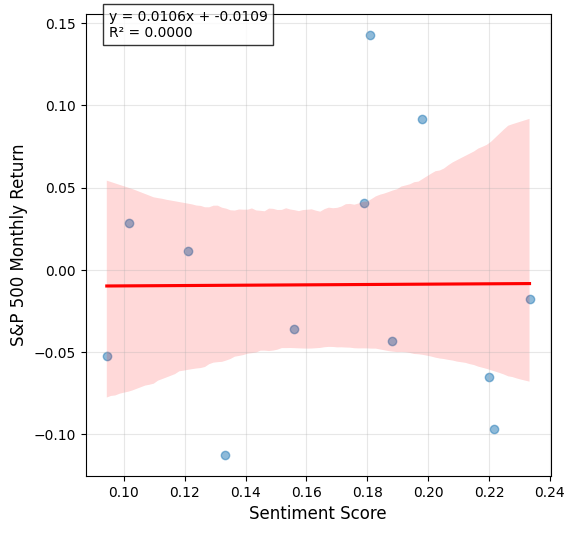


Regression Statistics:
R-squared: 0.0000
P-value: 0.9837
Slope: 0.0106
Intercept: -0.0109
Standard Error: 0.5046


In [95]:

# Create the regression plot
plt.figure(figsize=(6, 6))
sns.regplot(x='combined_sentiment', y='SP_return', data=monthly_sentiment,
            scatter_kws={'alpha':0.5},  # Make points slightly transparent
            line_kws={'color':'red'})   # Make regression line red

# Add labels and title
plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('S&P 500 Monthly Return', fontsize=12)
plt.grid(True, alpha=0.3)

# Calculate and display regression statistics
slope, intercept, r_value, p_value, std_err = stats.linregress(monthly_sentiment['combined_sentiment'], monthly_sentiment['SP_return'])

# Add regression equation to plot
equation = f'y = {slope:.4f}x + {intercept:.4f}'
r_squared = f'R² = {r_value**2:.4f}'
plt.text(0.05, 0.95, f'{equation}\n{r_squared}', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

# Print detailed statistics
print("\nRegression Statistics:")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"Standard Error: {std_err:.4f}")

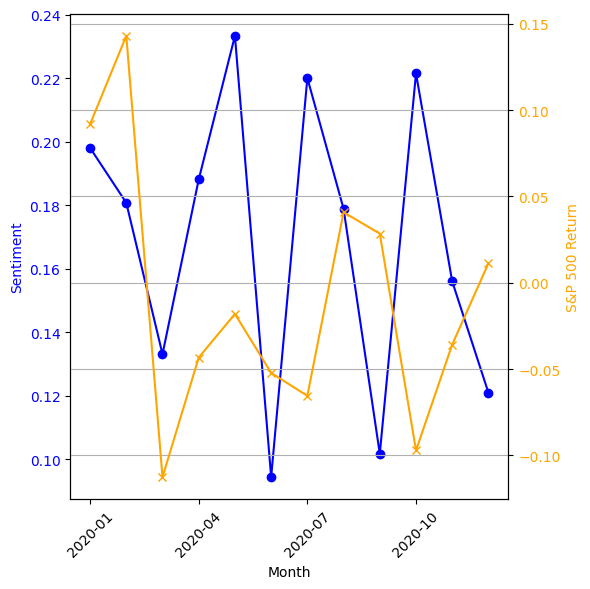

In [97]:

fig, ax1 = plt.subplots(figsize=(6, 6))

# Convert 'month' to a string format for plotting
ax1.set_xlabel('Month')
ax1.set_ylabel('Sentiment', color='blue')
ax1.plot(monthly_sentiment['month'].astype(str), monthly_sentiment['combined_sentiment'], label='Sentiment', color='blue', marker='o')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the S&P 500 return
ax2 = ax1.twinx()  
ax2.set_ylabel('S&P 500 Return', color='orange')  
ax2.plot(monthly_sentiment['month'].astype(str), monthly_sentiment['SP_return'], label='S&P 500 Return', color='orange', marker='x')
ax2.tick_params(axis='y', labelcolor='orange')

# Reduce x-axis ticks by showing every nth month
n = 3  # Show every 3rd month
months = monthly_sentiment['month'].astype(str)
ax1.set_xticks(months[::n])  # Set ticks for every nth month
ax1.set_xticklabels(months[::n], rotation=45)

fig.tight_layout()  
plt.grid(True)
plt.show()

## Market Trends: Fine-Tuned BERT

In [98]:

news_df_test = news_df.loc[news_df['publication_datetime'] >= '2020-01-01'].copy()
news_df_test.loc[:, 'sentiment'] = sentiment_scores

# monthly sentiment
news_df_test['publication_datetime'] = pd.to_datetime(news_df_test['publication_datetime'])
monthly_sentiment = news_df_test.groupby(news_df_test['publication_datetime'].dt.to_period('M'))['sentiment'].mean().reset_index(name='sentiment')
monthly_sentiment.columns = ['month', 'sentiment']


def calculate_sp_return(month):
    current_period = price_df.loc[
        (price_df['Date'] >= month.start_time) & 
        (price_df['Date'] < (month + 1).start_time) & 
        (price_df['ticker'] == 'SPX')
    ]
    
    next_period = price_df.loc[
        (price_df['Date'] >= (month + 1).start_time) & 
        (price_df['Date'] < (month + 2).start_time) & 
        (price_df['ticker'] == 'SPX')
    ]
    
    if not current_period.empty and not next_period.empty:
        return (current_period['close'].iloc[-1] / next_period['close'].iloc[-1]) - 1
    else:
        return None

monthly_sentiment['SP_return'] = monthly_sentiment['month'].apply(calculate_sp_return)

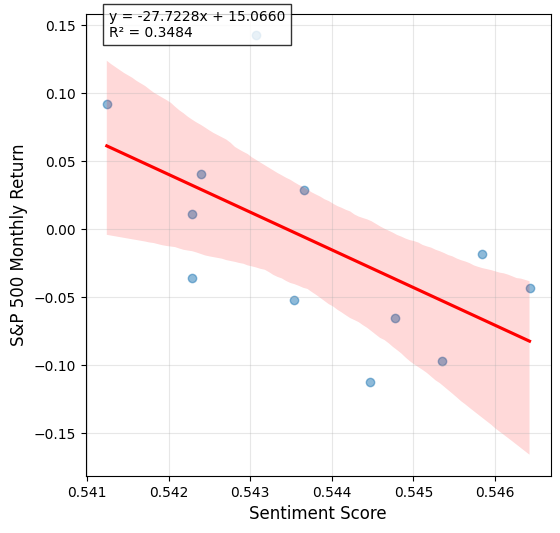


Regression Statistics:
R-squared: 0.3484
P-value: 0.0433
Slope: -27.7228
Intercept: 15.0660
Standard Error: 11.9894


In [ ]:
# Regression Analysis

# Create the regression plot
plt.figure(figsize=(6, 6))
sns.regplot(x='sentiment', y='SP_return', data=monthly_sentiment,
            scatter_kws={'alpha':0.5},  # Make points slightly transparent
            line_kws={'color':'red'})   # Make regression line red

# Add labels and title
plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('S&P 500 Monthly Return', fontsize=12)
plt.grid(True, alpha=0.3)

# Calculate and display regression statistics
slope, intercept, r_value, p_value, std_err = stats.linregress(monthly_sentiment['sentiment'], monthly_sentiment['SP_return'])

# Add regression equation to plot
equation = f'y = {slope:.4f}x + {intercept:.4f}'
r_squared = f'R² = {r_value**2:.4f}'
plt.text(0.05, 0.95, f'{equation}\n{r_squared}', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

# Print detailed statistics
print("\nRegression Statistics:")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"Standard Error: {std_err:.4f}")

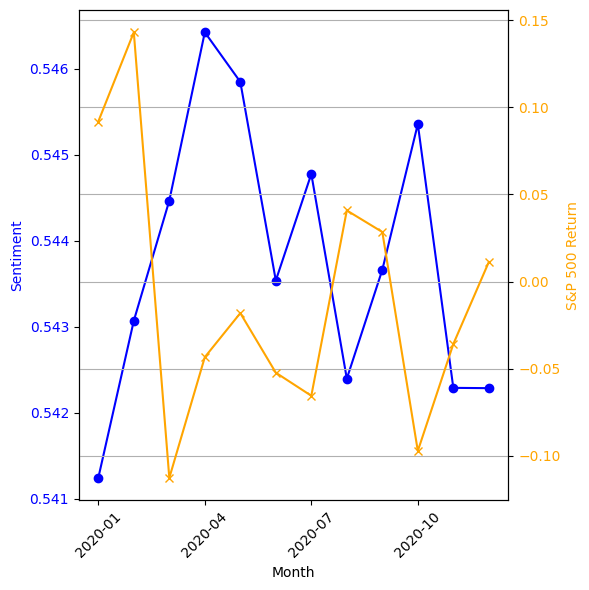

In [102]:
fig, ax1 = plt.subplots(figsize=(6, 6))

# Convert 'month' to a string format for plotting
ax1.set_xlabel('Month')
ax1.set_ylabel('Sentiment', color='blue')
ax1.plot(monthly_sentiment['month'].astype(str), monthly_sentiment['sentiment'], label='Sentiment', color='blue', marker='o')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the S&P 500 return
ax2 = ax1.twinx()  
ax2.set_ylabel('S&P 500 Return', color='orange')  
ax2.plot(monthly_sentiment['month'].astype(str), monthly_sentiment['SP_return'], label='S&P 500 Return', color='orange', marker='x')
ax2.tick_params(axis='y', labelcolor='orange')

# Reduce x-axis ticks by showing every nth month
n = 3  # Show every 3rd month
months = monthly_sentiment['month'].astype(str)
ax1.set_xticks(months[::n])  # Set ticks for every nth month
ax1.set_xticklabels(months[::n], rotation=45)

fig.tight_layout()  
plt.grid(True)
plt.xticks(rotation=45)
plt.show()